In [490]:
from functools import partial
import sys
# sys.path.append('../src')
import KBio
import numpy as np
import matplotlib.pyplot as plt

import math


In [491]:
# p = KBio.Polynomial(degree = 3, c=0.1)
p = KBio.Gaussian(sigma=2e-1)
p_kernel = p

In [492]:
np.random.seed(7)

In [493]:

# Define parameters for the 1D Advection simulation
dt = 0.01
nx = 500

nx_coarse = 50
dt_coarse = 0.1

T_final = 1  # Final time
tsteps = math.ceil(T_final / dt)  # Number of time steps
tsteps_coarse = math.ceil(T_final / dt_coarse)  # Number of time steps

# u0 = np.sin(np.linspace(0, 2 * np.pi, nx))  # Initial condition on [0,1]

def u0(x):
    return 1 + np.sin(2 * np.pi * x)

def ux(x):
    return 2 + np.sin(4 * np.pi * x)


# Color equation parameterization
c = 1
def ux_const(x, c=c):
    return c

# Forcing function psi

def psi(t, x):
    # return 0
    return (x ** 2 - t) / 20

# Create a rectangular grid for the simulation
# time, then x.
# u[i, :] is the solution at time i
grid = KBio.rectangular_grid(mins=np.array([0, 0]), maxes=[T_final, 1], n_pts=[tsteps_coarse+1, nx_coarse])

# Create an instance of the Advection1D class
advection_sim = KBio.Advection1D_sim(dt, u0=u0, T_final=T_final, forcing = lambda q,x,t: 0, nx=nx, ux=ux)

# Run the simulation
t_, x_, u_, ffun, ufun = advection_sim(grid, forcing=psi, pyvis=False)


2024-06-07 14:43:18,819 INFO CLAW: Solution 0 computed for time t=0.000000
2024-06-07 14:43:18,826 INFO CLAW: Solution 1 computed for time t=0.010000
2024-06-07 14:43:18,832 INFO CLAW: Solution 2 computed for time t=0.020000
2024-06-07 14:43:18,838 INFO CLAW: Solution 3 computed for time t=0.030000
2024-06-07 14:43:18,844 INFO CLAW: Solution 4 computed for time t=0.040000
2024-06-07 14:43:18,850 INFO CLAW: Solution 5 computed for time t=0.050000
2024-06-07 14:43:18,856 INFO CLAW: Solution 6 computed for time t=0.060000
2024-06-07 14:43:18,863 INFO CLAW: Solution 7 computed for time t=0.070000
2024-06-07 14:43:18,869 INFO CLAW: Solution 8 computed for time t=0.080000
2024-06-07 14:43:18,874 INFO CLAW: Solution 9 computed for time t=0.090000
2024-06-07 14:43:18,880 INFO CLAW: Solution 10 computed for time t=0.100000
2024-06-07 14:43:18,886 INFO CLAW: Solution 11 computed for time t=0.110000
2024-06-07 14:43:18,893 INFO CLAW: Solution 12 computed for time t=0.120000
2024-06-07 14:43:18,89

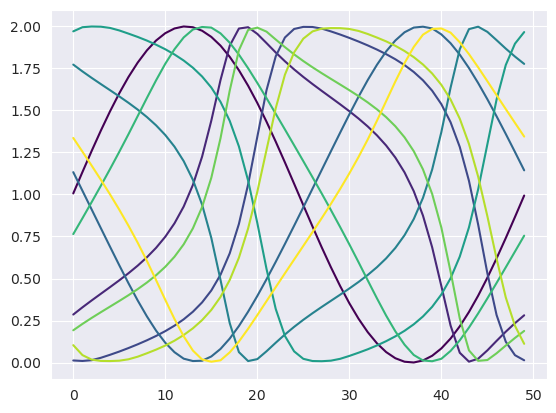

In [494]:
colors = plt.cm.viridis(np.linspace(0, 1, tsteps_coarse))
for t in range(tsteps_coarse):
    # print(t)
    plt.plot(grid.grid_tensors_values[t, :], color=colors[t])

In [495]:
# A simple forcing function to consider

def psi_simple(x, t, b, omega_1=0, omega_2=0):
    return b * np.sin(6 * np.pi * x + omega_1) * np.sin(6 * np.pi * t + omega_2)
    # return b * x  * (1-x) * t * (1 - t)

Use 21x21 grids

In [496]:
# Generate a function that returns the following math calculation
# u(x,a,b) = A1 * exp(-b(x-mu[0])^2) - A1 * exp(-b(x-mu[1])^2)


In [497]:
noise_b_std = 1

In [498]:
n_train = 10
# Anisotropic grid
dt = 0.005
nx = 201
nx_coarse = 20
dt_coarse = 1 / (nx_coarse - 1)
T_final = 1  # Final time
tsteps = math.ceil(T_final / dt)  # Number of time steps
tsteps_coarse = math.ceil(T_final / dt_coarse)  # Number of time steps



# speed_c_values = np.random.normal(2, 0.2, n_train)  * np.random.choice([-1, 1], n_train)
np.random.seed(7)
speed_c_values = np.ones(n_train)
print(speed_c_values)
forcing_b_values = np.random.normal(10, noise_b_std, n_train)
# x_max = 0.5

# mu_parameters = np.random.gamma(shape=4, scale=0.1, size=(n_train,2))
# b_parameters = np.random.gamma(shape=32, scale=0.2, size=(n_train,2))
mu_parameters = np.ones((n_train, 2)) * 0.5
mu_parameters[:,0] += 0.25
mu_parameters[:,1] -= 0.25

b_parameters = np.ones((n_train, 2)) * 5
# def u0(x):
#     return 1 + np.sin(2 * np.pi * x)

def ux(x, c):
    return c * (2 + np.sin(4 * np.pi * x)) / 2

def u(x, mu0, mu1, b0, b1):
    return  np.exp(-b0 * (x - mu0) ** 2) - np.exp(-b1 * (x - mu1) ** 2)

u0_funcs = [partial(u, mu0=mu_parameters[i,0], mu1=mu_parameters[i,1], b0=b_parameters[i,0], b1=b_parameters[i,1]) for i in range(n_train)]

forcings = [partial(psi_simple, b=b) for b in forcing_b_values]
speed_functions = [partial(ux, c=c) for c in speed_c_values]
# sim = KBio.Advection1D_sim(dt, u0=u0, T_final=T_final, forcing = lambda t, x: 0, nx=nx, ux=ux)
grid_train = [KBio.rectangular_grid(mins=np.array([0, 0]), maxes=[T_final, 1], n_pts=[tsteps_coarse+1, nx_coarse]) for _ in range(n_train)]
sim = KBio.Advection1D_sim(dt, u0=u0, T_final=T_final, forcing = lambda q,x,t: 0, nx=nx, ux=ux)

for grid, fn, u0, ux in zip(grid_train, forcings, u0_funcs, speed_functions):
    sim(grid, forcing = fn, u0=u0, ux=ux)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Using custom u0
2024-06-07 14:43:24,925 INFO CLAW: Solution 0 computed for time t=0.000000
2024-06-07 14:43:24,927 INFO CLAW: Solution 1 computed for time t=0.005000
2024-06-07 14:43:24,929 INFO CLAW: Solution 2 computed for time t=0.010000
2024-06-07 14:43:24,930 INFO CLAW: Solution 3 computed for time t=0.015000
2024-06-07 14:43:24,931 INFO CLAW: Solution 4 computed for time t=0.020000
2024-06-07 14:43:24,933 INFO CLAW: Solution 5 computed for time t=0.025000
2024-06-07 14:43:24,934 INFO CLAW: Solution 6 computed for time t=0.030000
2024-06-07 14:43:24,935 INFO CLAW: Solution 7 computed for time t=0.035000
2024-06-07 14:43:24,936 INFO CLAW: Solution 8 computed for time t=0.040000
2024-06-07 14:43:24,937 INFO CLAW: Solution 9 computed for time t=0.045000
2024-06-07 14:43:24,939 INFO CLAW: Solution 10 computed for time t=0.050000
2024-06-07 14:43:24,940 INFO CLAW: Solution 11 computed for time t=0.055000
2024-06-07 14:43:24,941 INFO CLAW: Solution 12 com

In [499]:
n_test = 4
# Anisotropic grid
# dt = 0.02
# nx = 50
# T_final = 1  # Final time
# tsteps = math.ceil(T_final / dt)  # Number of time steps
np.random.seed(1238914)
# speed_c_values_test = np.random.normal(2, 0.2, n_test) * np.random.choice([-1, 1], n_test)
speed_c_values_test = np.ones(n_test)
print(speed_c_values_test)
forcing_b_values = np.random.normal(10, noise_b_std, n_test)
x_max = 0.5

sim = KBio.Advection1D_sim(dt, u0=u0, T_final=T_final, forcing = lambda t, x: 0, nx=nx, ux=ux)

forcings_test = [partial(psi_simple, b=b) for b in forcing_b_values]

mu_parameters = np.ones((n_test, 2)) * 0.5
mu_parameters[:,0] += 0.25
mu_parameters[:,1] -= 0.25
b_parameters = np.ones((n_test, 2)) * 5


u0_funcs_test = [partial(u, mu0=mu_parameters[i,0], mu1=mu_parameters[i,1], b0=b_parameters[i,0], b1=b_parameters[i,1]) for i in range(n_test)]

def ux(x, c):
    return c * (2 + np.sin(4 * np.pi * x)) / 2

def u(x, mu0, mu1, b0, b1):
    return  np.exp(-b0 * (x - mu0) ** 2) - np.exp(-b1 * (x - mu1) ** 2)


speed_functions_test = [partial(ux, c=c) for c in speed_c_values_test]


grid_test = [KBio.rectangular_grid(mins=np.array([0, 0]), maxes=[T_final, 1], n_pts=[tsteps_coarse+1, nx_coarse]) for _ in range(n_test)]
for grid, fn, u0, ux in zip(grid_test, forcings_test, u0_funcs_test, speed_functions_test):
    sim(grid, forcing = fn, u0=u0, ux=ux)
# for grid, fn in zip(grid_test, forcings_test):
    # sim(grid, forcing = fn)

[1. 1. 1. 1.]
Using custom u0
2024-06-07 14:43:28,096 INFO CLAW: Solution 0 computed for time t=0.000000
2024-06-07 14:43:28,100 INFO CLAW: Solution 1 computed for time t=0.005000
2024-06-07 14:43:28,102 INFO CLAW: Solution 2 computed for time t=0.010000
2024-06-07 14:43:28,104 INFO CLAW: Solution 3 computed for time t=0.015000
2024-06-07 14:43:28,105 INFO CLAW: Solution 4 computed for time t=0.020000
2024-06-07 14:43:28,106 INFO CLAW: Solution 5 computed for time t=0.025000
2024-06-07 14:43:28,107 INFO CLAW: Solution 6 computed for time t=0.030000
2024-06-07 14:43:28,109 INFO CLAW: Solution 7 computed for time t=0.035000
2024-06-07 14:43:28,110 INFO CLAW: Solution 8 computed for time t=0.040000
2024-06-07 14:43:28,111 INFO CLAW: Solution 9 computed for time t=0.045000
2024-06-07 14:43:28,113 INFO CLAW: Solution 10 computed for time t=0.050000
2024-06-07 14:43:28,115 INFO CLAW: Solution 11 computed for time t=0.055000
2024-06-07 14:43:28,116 INFO CLAW: Solution 12 computed for time t=0

## Now we calculate derivatives

In [500]:
nugget_smoothing = 1e-8

In [501]:
# Reformat the data into a format that can be used by the Kernel
smoothed_data = []
smoothed_derivatives = []
alphas_list = [[0,0], [0,1], [1,0]]
x_data_train = np.asarray([grid.grid_list for grid in grid_train])
# standardize x_data to mean 0 variance 1
x_mean = np.mean(np.asarray(x_data_train), axis=1)  # take over middle "points" axis
x_std = np.std(np.asarray(x_data_train), axis=1)
x_data_train = (x_data_train - x_mean[0,:]) / x_std[0,:]

y_data_train = np.stack([grid.grid_tensors_values for grid in grid_train])
y_data_train = y_data_train.reshape((n_train, -1))
# y_data += np.random.normal(0, 1e-3, y_data.shape)
f_data_train = np.stack([grid.grid_tensors_forcing for grid in grid_train])

z, kdList, u_smoothed = KBio.kernel_smoothing(p, x_grid = x_data_train, u_data = y_data_train, f_data = f_data_train, alpha_list=alphas_list, nugget=nugget_smoothing)
# u_smoothed

n_grid_pts:  400


In [502]:
x_data_train.shape

(10, 400, 2)

In [503]:
x_mean.shape

(10, 2)

In [504]:
y_data_train.shape

(10, 400)

In [505]:
y_data_train.shape

(10, 400)

In [506]:
f_data_train.shape

(10, 20, 20)

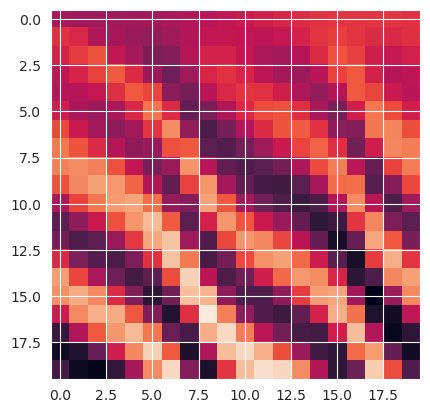

In [507]:
plt.imshow(grid_train[0].grid_tensors_values)

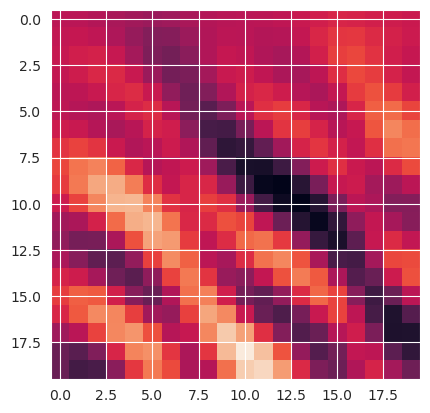

In [508]:
plt.imshow(u_smoothed[0][:,0].reshape((tsteps_coarse+1, nx_coarse)))

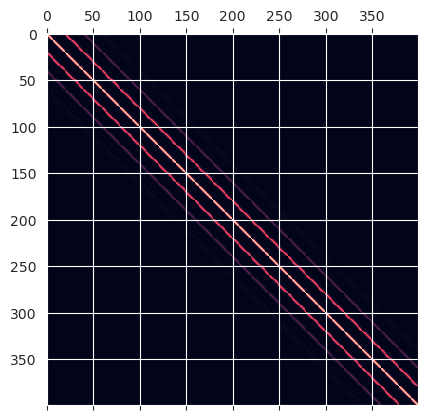

In [509]:
plt.matshow(kdList[0])

In [510]:
u_smoothed[0].shape

(400, 10)

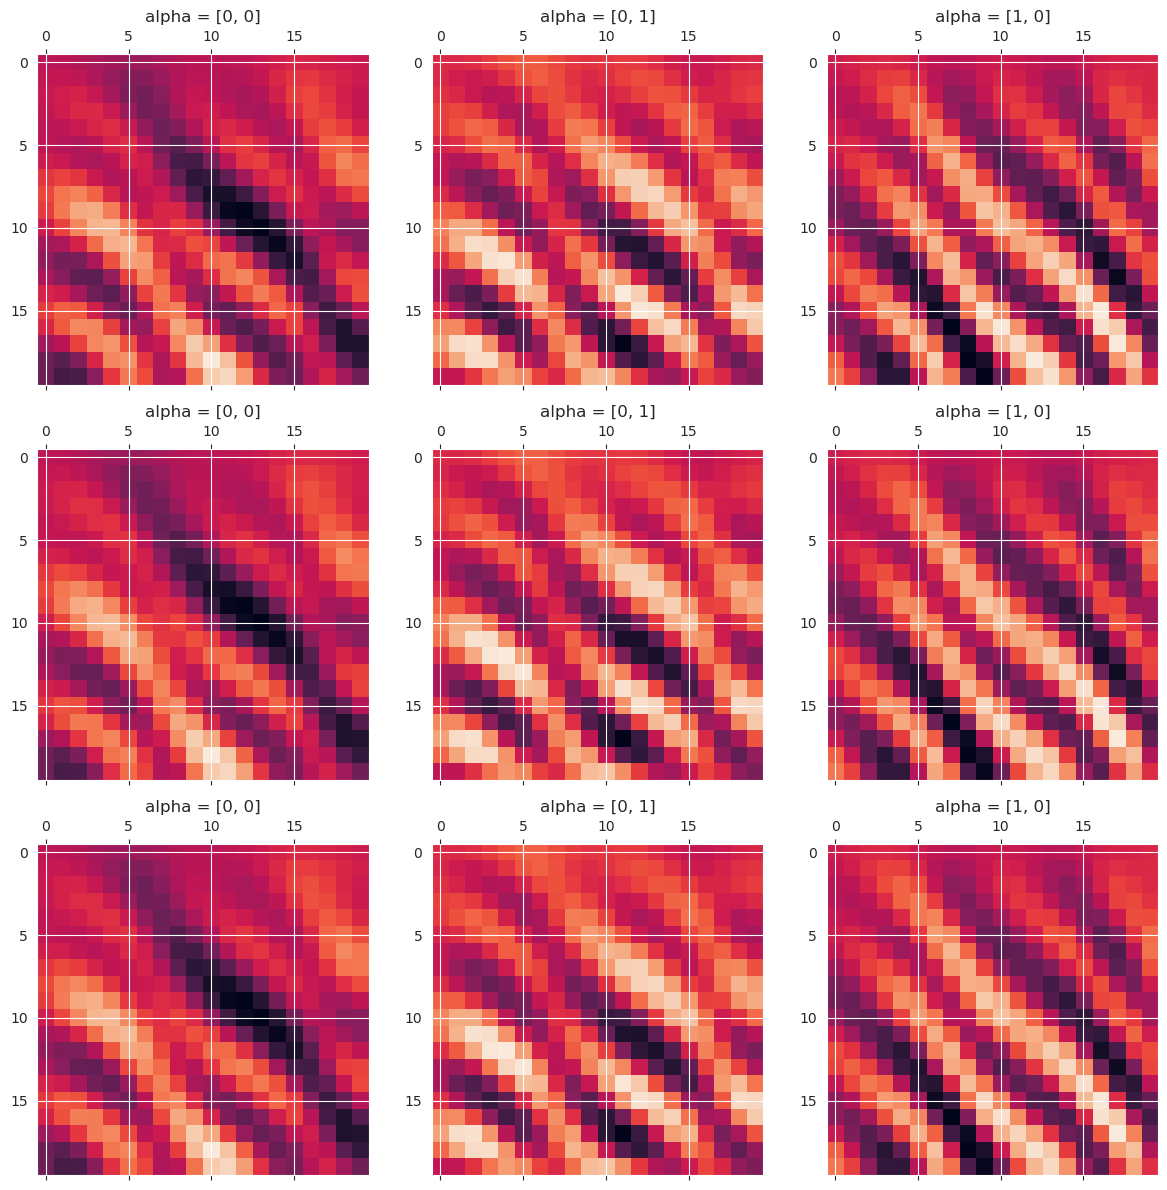

In [511]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    # This line works:
    # u_smoothed[0][:,0].reshape((tsteps+1, nx))
    # This one does not:
    for j in range(3):
        us = u_smoothed[i][:,j].reshape((tsteps_coarse+1, nx_coarse))
        ax[j,i].matshow(us)
        ax[i,j].set_title(f"alpha = {alphas_list[j]}")
        # ax[i,j].show()
plt.tight_layout()

## Assemble features

In [512]:
feature_functions = []

def ident(index, x, u, u_deriv_list):
    """ Identity feature function for the $index$-th derivative of the function"""
    if np.abs(int(index) - index) > 1e-10:
        raise ValueError('Only the first derivative is available')
    if index == 0:
        return u
    else:
        return u_deriv_list[index]
# Get the first 2 derivatives and the function itself
for i in range(1,3):
    pass
    # feature_functions.append(partial(ident, i))

# quadratic feature function
def quadratic(index, x, u, u_deriv_list):
    """ Quadratic feature function for the $index$-th derivative of the function

    The feature function is $u^2$ for the function itself and $2u u'$ for the first derivative.
    """

    if index == 0:
        return u**2
    else:
        return 2*u*u_deriv_list[index]
    # elif index == 1:
        # return 2*u*u_deriv_list[index]

# feature_functions.append(partial(quadratic, 0))
# feature_functions.append(partial(quadratic, 1))
# feature_functions.append(partial(quadratic, 2))

In [513]:
x_grid_list = grid.grid_list  # Get the grid of points as a list
# F0 = KBio.assemble_features(x_grid_list=x_grid_list, u_smoothed=u_smoothed[0], multi_derivatives=u_smoothed, function_list=feature_functions)
F0_train = KBio.assemble_features(x_grid_list=x_grid_list, u_smoothed=u_smoothed[0], multi_derivatives=u_smoothed[1:], function_list=feature_functions, flatten=False)
points_per_example = F0_train.shape[1]

F0_train = F0_train.reshape((-1, F0_train.shape[-1]))
F0_mean = np.mean(F0_train, axis=0)
F0_std = np.std(F0_train, axis=0)
F0 = np.divide((F0_train - F0_mean), F0_std, where = (F0_std != 0))

f_data_flat = f_data_train.reshape(-1)
f_data_flat.shape

(4000,)

In [514]:
u_smoothed[0].shape

(400, 10)

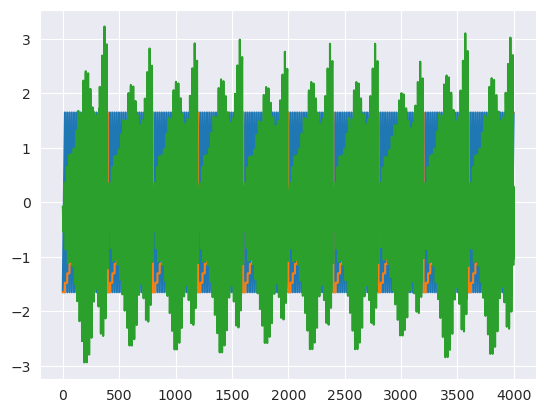

In [515]:
plt.plot(F0[:,0:3])

In [516]:
F0_mean

array([ 0.5       ,  0.5       ,  3.64150041, -3.64157472,  0.87755258])

In [517]:
F0_std

array([3.03488489e-01, 3.03488489e-01, 4.28041437e+01, 3.30416478e+02,
       3.27968795e+02])

In [518]:
F0.shape

(4000, 5)

In [519]:
# q = KBio.Polynomial(degree=1, c=0)
q = KBio.Gaussian(sigma=5e-1)

In [520]:
f_data_flat.shape

(4000,)

In [521]:
F0.shape

(4000, 5)

In [522]:
# F0_flat = F0.reshape(-1, F0.shape[2])

In [523]:
f_data_flat.shape

(4000,)

In [524]:
predictor, weight_vector = KBio.learn_DE_form(kernel=q, s_features=F0, f_labels=f_data_flat, nugget=1e-1)

In [525]:
matrix, preds = predictor(F0)

(4000, 4000) (4000,)


In [526]:
preds.shape

(4000,)

In [527]:
preds3d = preds.reshape((n_train, tsteps_coarse+1, nx_coarse))

In [528]:
preds3d.shape

(10, 20, 20)

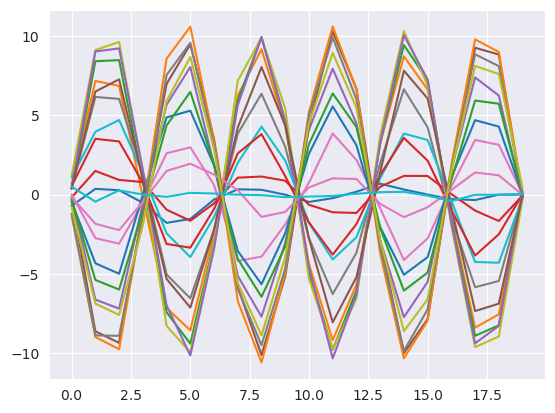

In [529]:
plt.plot(preds3d[0])

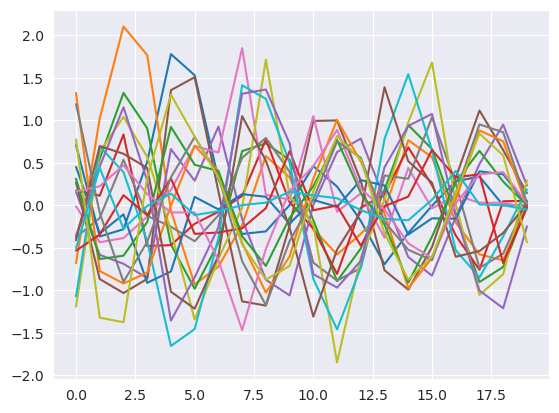

In [530]:
plt.plot(f_data_train[0] - preds3d[0])

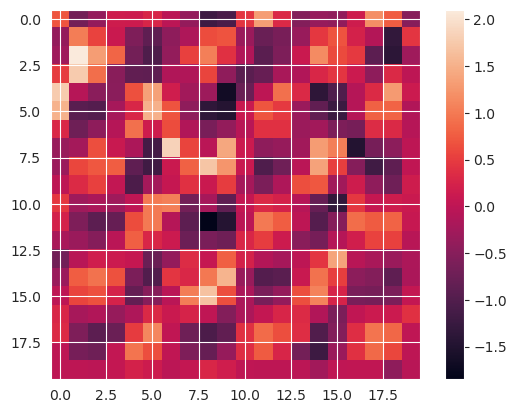

In [531]:
plt.imshow(f_data_train[0].reshape(nx_coarse,nx_coarse) - preds3d[0].reshape(nx_coarse,nx_coarse))
plt.colorbar()

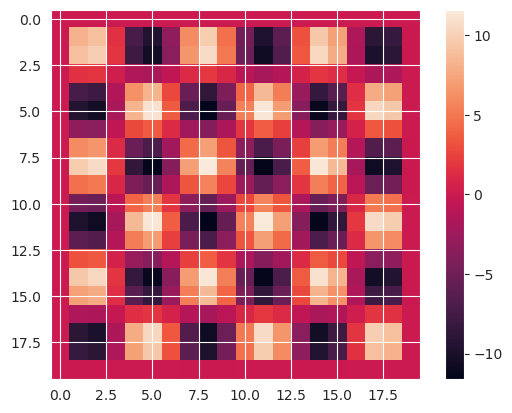

In [532]:
plt.imshow(f_data_train[0].reshape(nx_coarse,nx_coarse))
plt.colorbar()

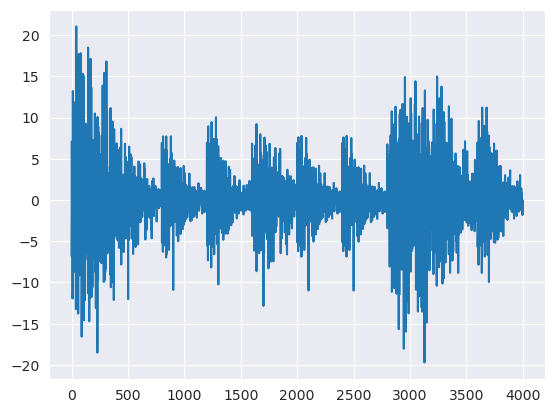

In [533]:
plt.plot(weight_vector)

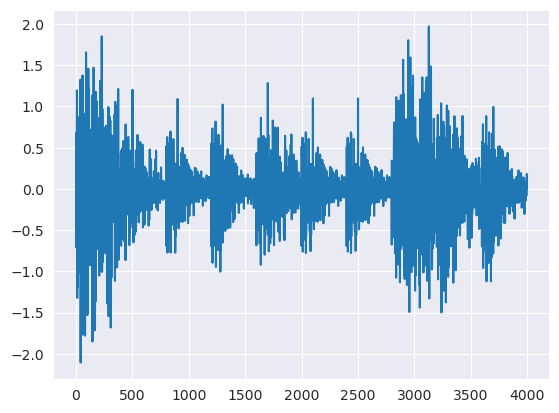

In [534]:
plt.plot(preds - f_data_flat)
# plt.plot()

In [535]:
weight_vector.shape

(4000,)

## Test the model we discovered

In [536]:
f_data_test = np.stack([grid.grid_tensors_forcing for grid in grid_test])

In [537]:
# Reformat the data into a format that can be used by the Kernel
# smoothed_data = []
# smoothed_derivatives = []
# alphas_list = [[0,0], [0,1], [1,0]]
x_data_test = np.asarray([grid.grid_list for grid in grid_test])
# standardize x_data to mean 0 variance 1
# x_mean = np.mean(np.asarray(x_data), axis=1)  # take over middle "points" axis
# x_std = np.std(np.asarray(x_data), axis=1)
x_data_test = (x_data_test - x_mean[0,:]) / x_std[0,:]

y_data_test = np.stack([grid.grid_tensors_values for grid in grid_test])
y_data_test = y_data_test.reshape((n_test, -1))
# y_data += np.random.normal(0, 1e-3, y_data.shape)
f_data_test = np.stack([grid.grid_tensors_forcing for grid in grid_test])

z_test, kdList_test, u_smoothed_test = KBio.kernel_smoothing(p, x_grid = x_data_test, u_data = y_data_test, f_data = f_data_test, alpha_list=alphas_list, nugget=nugget_smoothing)
# u_smoothed

n_grid_pts:  400


In [538]:
F0_test = KBio.assemble_features(x_grid_list=x_grid_list, u_smoothed=u_smoothed_test[0], multi_derivatives=u_smoothed_test[1:], function_list=feature_functions, flatten=False)
# standardize the test data
F0_test = F0_test.reshape((-1, F0_test.shape[-1]))
# F0_mean = np.mean(F0_train, axis=0)
# F0_std = np.std(F0_train, axis=0)


F0_test = np.divide((F0_test - F0_mean), F0_std, where = (F0_std != 0))

f_data_flat_test = f_data_test.reshape(-1)
f_data_flat_test.shape

(1600,)

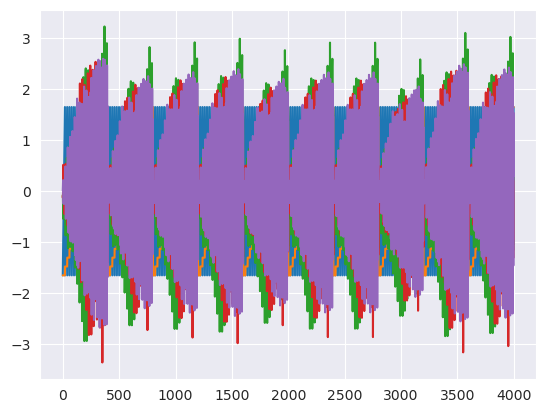

In [539]:
plt.plot(F0)

In [540]:
k_new, preds_all = predictor(F0_test)
preds_all = preds_all.reshape((n_test, tsteps_coarse+1, nx_coarse))

(1600, 4000) (4000,)


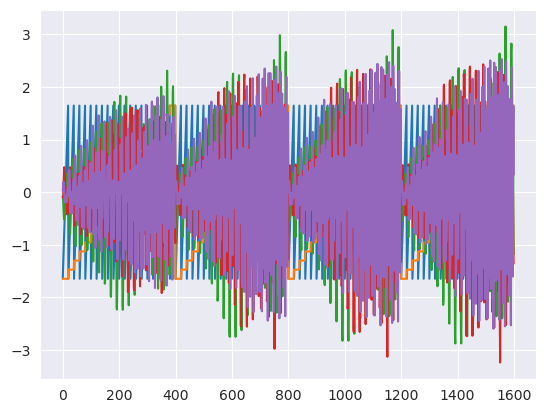

In [541]:
plt.plot(F0_test)

In [542]:
preds_all.mean()

0.004864226741361954

In [543]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [545]:
sns.set_style("white")

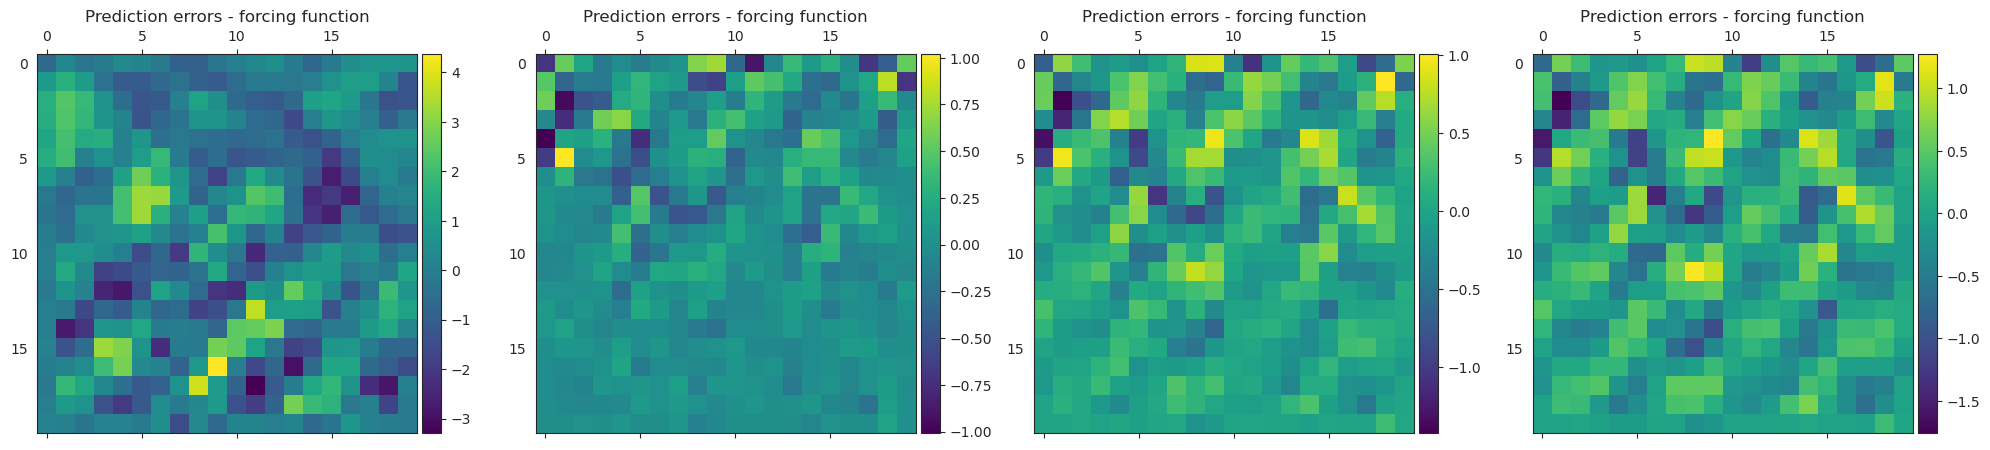

In [546]:
# n_test = 2
n_test_plot = 4
fig, ax = plt.subplots(1, n_test, figsize=(5* n_test_plot,5))
for i in range(n_test_plot):
    pr = preds_all[i]#.reshape((tsteps_coarse+1, nx_coarse))
    im = ax[i].matshow(pr - f_data_test[i], label='Predicted', cmap="viridis")
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    ax[i].set_title("Prediction errors - forcing function")
    # ax[i].set_colorbar(im)
    fig.colorbar(im, cax=cax, orientation='vertical')
    # ax[i].matshow(f_data_test[i], label='True')
plt.tight_layout()

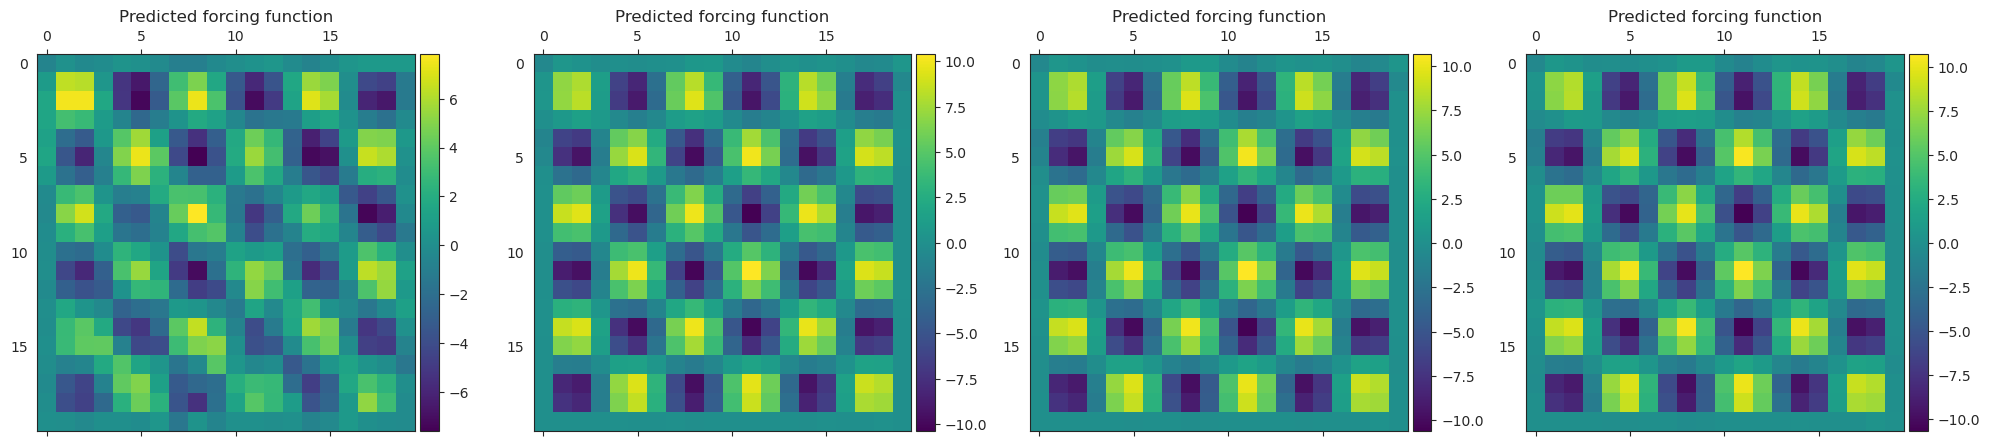

In [547]:

fig, ax = plt.subplots(1, n_test, figsize=(5 * n_test_plot, 5))
for i in range(n_test_plot):
    pr = preds_all[i]#.reshape((tsteps_coarse+1, nx_coarse))
    im = ax[i].matshow(pr, label='Predicted', cmap="viridis")
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    ax[i].set_title("Predicted forcing function")
    # ax[i].set_colorbar(im)
    fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()    # ax[i].matshow(f_data_test[i], label='True')

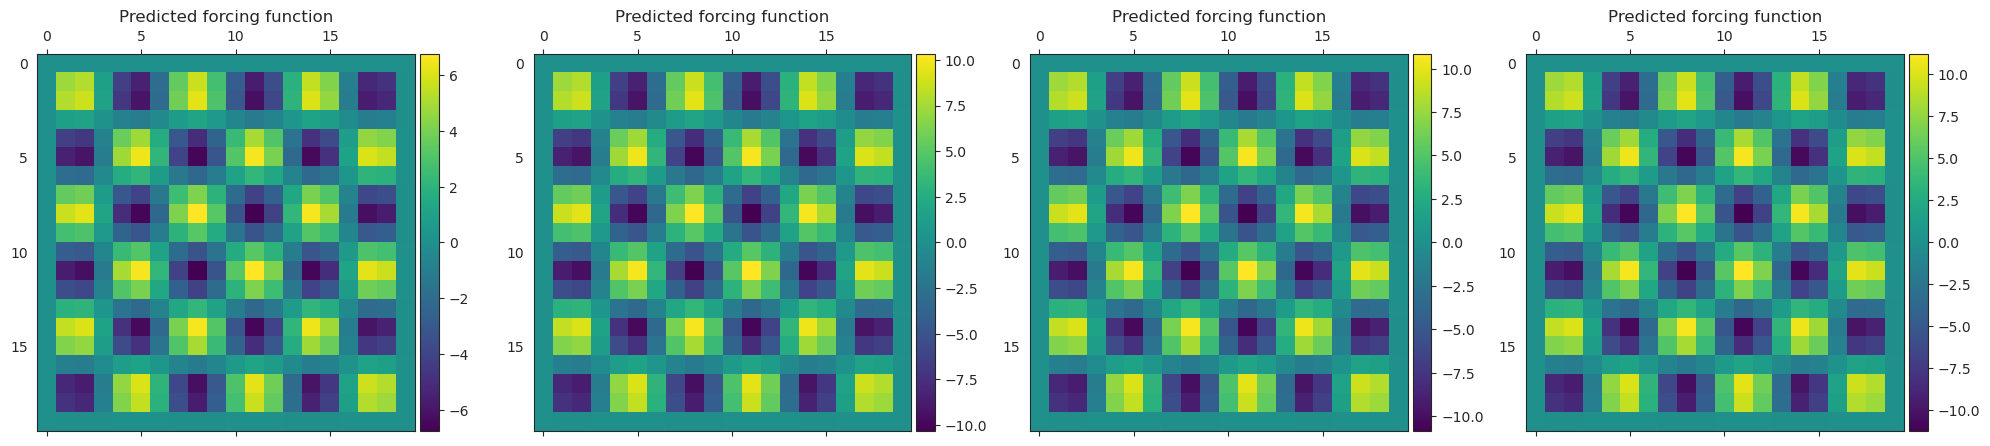

In [548]:

fig, ax = plt.subplots(1, n_test, figsize=(5 * n_test_plot, 5))
for i in range(n_test_plot):
    pr = preds_all[i]#.reshape((tsteps_coarse+1, nx_coarse))
    im = ax[i].matshow(f_data_test[i], label='Predicted', cmap="viridis")
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    ax[i].set_title("Predicted forcing function")
    # ax[i].set_colorbar(im)
    fig.colorbar(im, cax=cax, orientation='vertical')
    # ax[i].matshow(f_data_test[i], label='True')
plt.tight_layout()

Let's put all three of these plots together.

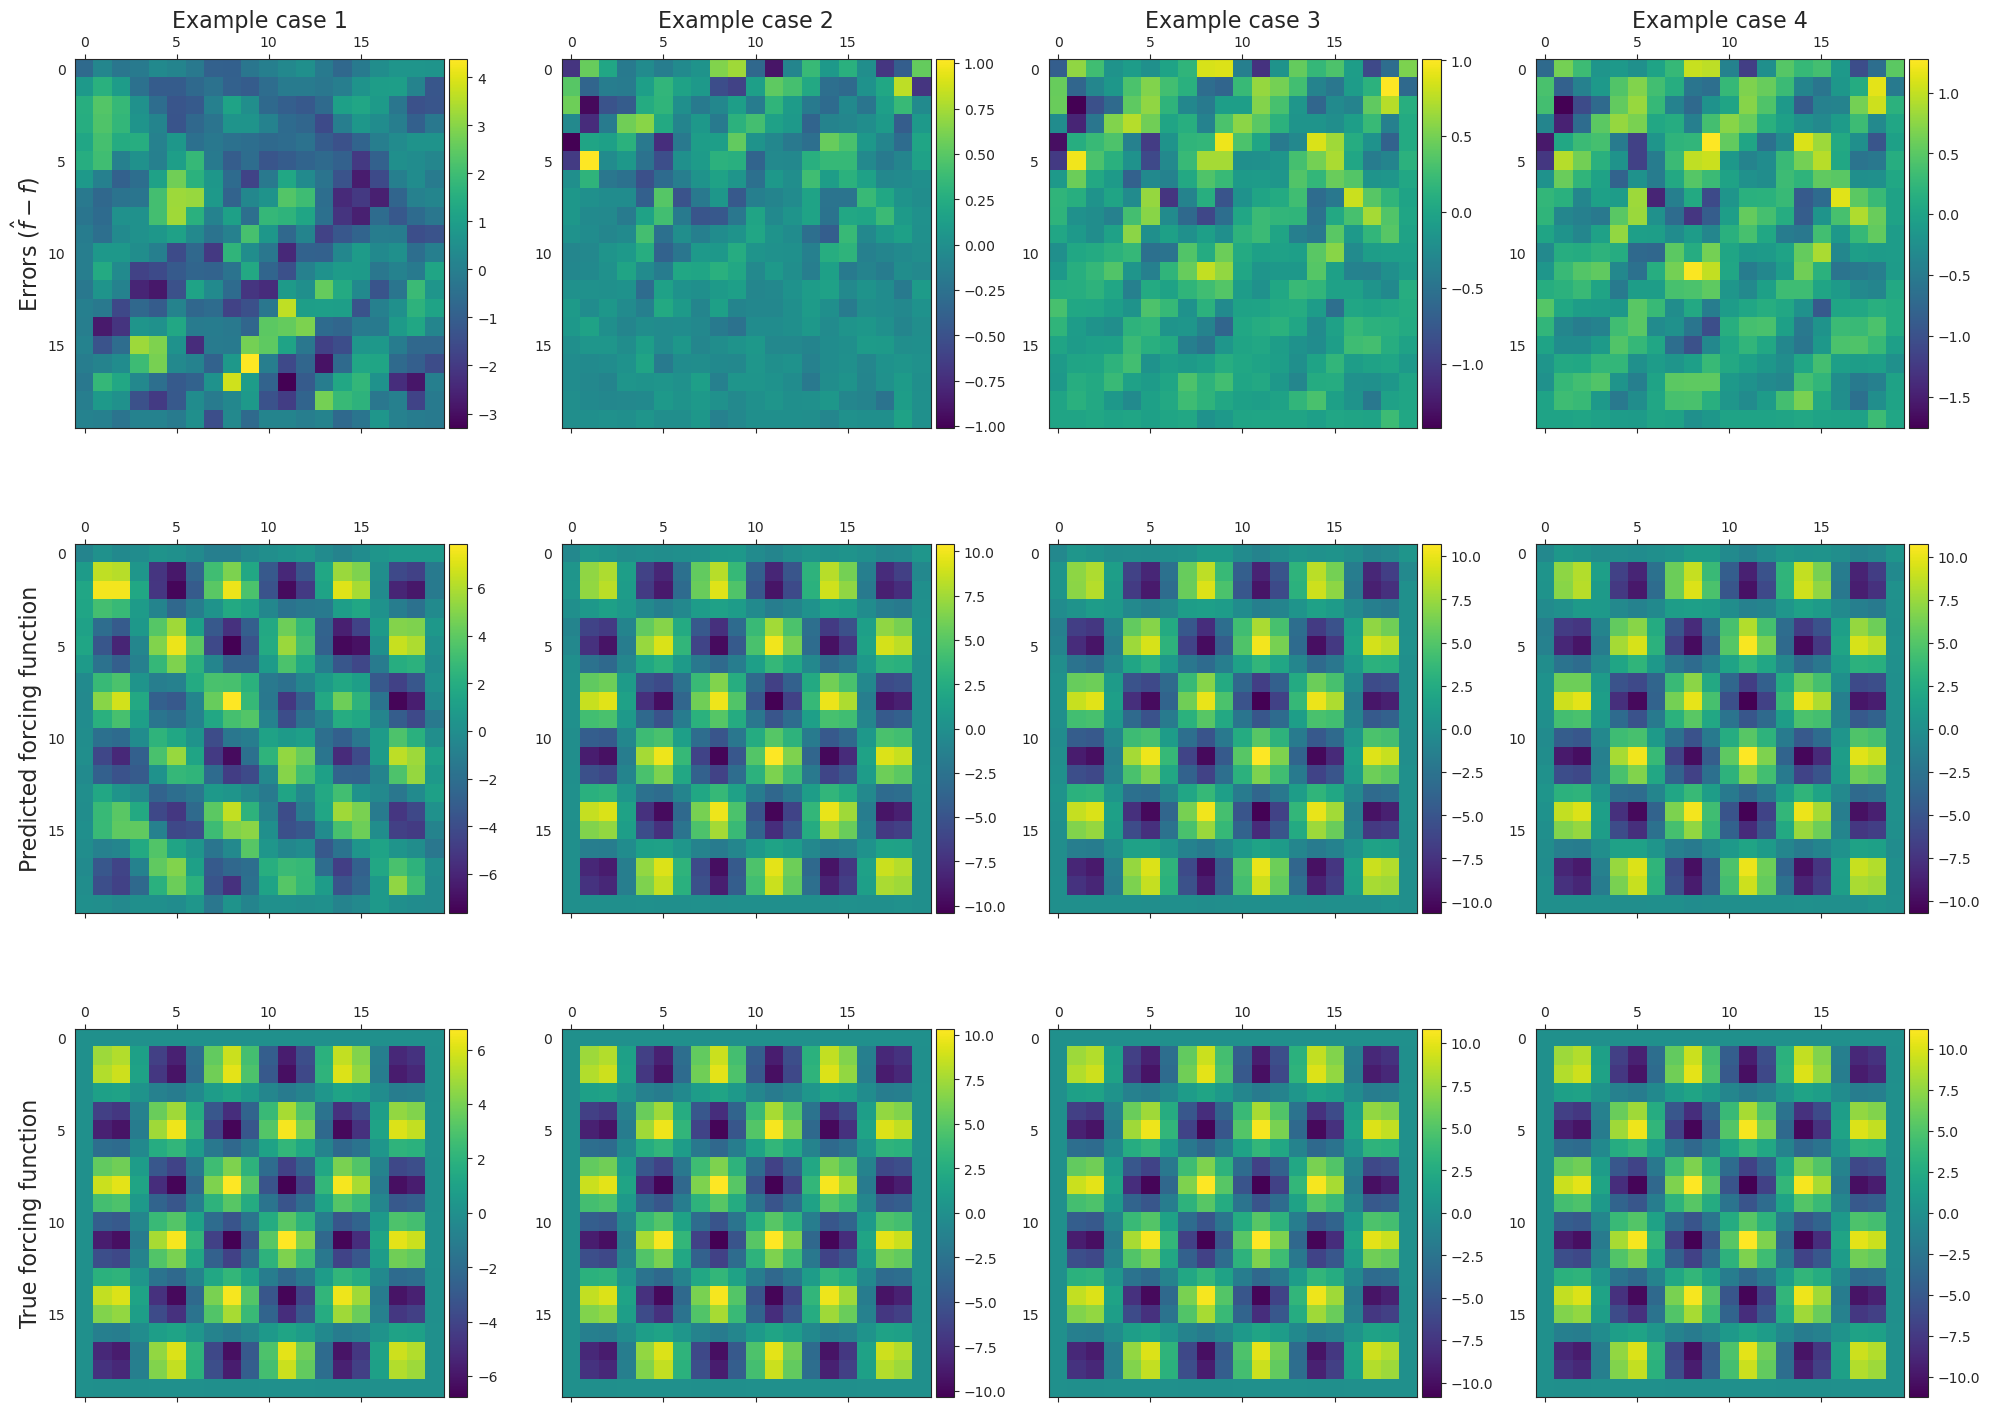

In [549]:
# n_test = 2
n_test_plot = 4
fig, ax = plt.subplots(3, n_test, figsize=(5* n_test_plot,15))
for i in range(n_test_plot):
    pr = preds_all[i]#.reshape((tsteps_coarse+1, nx_coarse))
    im = ax[0,i].matshow(pr - f_data_test[i], label='Predicted', cmap="viridis")
    divider = make_axes_locatable(ax[0,i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    if i == 0:
        ax[0,i].set_ylabel(r"Errors $(\hat f - f)$", fontsize=16)
    # ax[i].set_colorbar(im)
    ax[0,i].set_title(f"Example case {i+1}", fontsize=16)
    fig.colorbar(im, cax=cax, orientation='vertical')
    # ax[i].matshow(f_data_test[i], label='True')

    # pr = preds_all[i]#.reshape((tsteps_coarse+1, nx_coarse))
    im = ax[1,i].matshow(pr, label='Predicted', cmap="viridis")
    divider = make_axes_locatable(ax[1,i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    if i == 0:
        ax[1,i].set_ylabel("Predicted forcing function", fontsize=16)
    # ax[i].set_colorbar(im)
    fig.colorbar(im, cax=cax, orientation='vertical')

    pr = preds_all[i]#.reshape((tsteps_coarse+1, nx_coarse))
    im = ax[2,i].matshow(f_data_test[i], label='Predicted', cmap="viridis")
    divider = make_axes_locatable(ax[2,i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    if i == 0:
        ax[2,i].set_ylabel("True forcing function", fontsize=16)
    # ax[i].set_colorbar(im)
    fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()

# save it to a file
for fmt in ['pdf', 'png', 'svg', 'eps']:
    plt.savefig(f'../Figures/predictions_advection_toy_model.{fmt}', format=fmt)
    # plt.savefig(f'forcing_function_prediction_{fmt}.pdf', format=fmt)


## Real Data

In [69]:
import pandas as pd

In [87]:
real_data = pd.read_csv("../RealData/Clean/SEEPS_Simulation_1.csv")
real_data["t"] = real_data["tau"] / 120
# filter rows of real_data by p > 0.5
real_data = real_data[real_data["p"] > 0.5]

In [88]:
real_data.head()

,tau,p,MaxPop,R0,y_rt,y_rm,y_rtm,y_rmm,t
11000,0.0,0.9,6886.937531,4.980320,0.217280,0.167776,0.201613,0.203252,0.0
11001,0.0,0.9,3178.598279,2.432326,0.388622,0.239673,0.484914,0.220353,0.0
11002,0.0,0.9,1009.790488,1.680147,0.307606,0.153406,0.330033,0.090349,0.0
11003,0.0,0.9,1123.805265,2.716167,0.322421,0.235063,0.216195,0.196256,0.0
11004,0.0,0.9,3127.099807,4.711149,0.238971,0.158162,0.082237,0.128205,0.0


In [194]:
# mask for every 10'th row
mask = real_data.index % 10 == 0
t = real_data["t"].values
t = t[mask]
x = real_data["R0"].values
x = x[mask]
# p = real_data["p"].values
y_rt = real_data["y_rt"].values
y_rt = y_rt[mask]

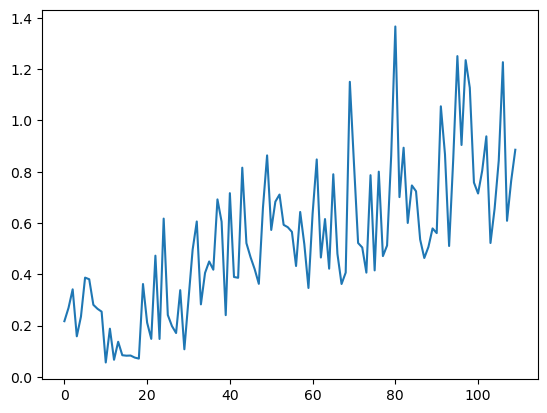

In [195]:
plt.plot(y_rt)

In [154]:
points_mesh_list = [(t_, x_) for t_, x_ in zip(t, x)]

In [155]:
np.asarray(points_mesh_list).max(axis=0)

array([1.        , 4.99969734])

In [156]:
# Let's run the real data through the model

In [157]:
class grid_manual(KBio.Grid):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def _fill_value_store(self) -> None:
        pass

    def _grid_to_points(self) -> None:
        pass

    def grid_generator(self, quiet=True) -> None:
        pass


In [158]:
grid = grid_manual()
grid_manual.grid_list = points_mesh_list
grid_manual.grid_tensors_values = y_rt
grid_manual.value_list = y_rt

In [159]:
p

In [160]:
points_mesh = np.asarray(points_mesh_list)[np.newaxis, :, :]

In [161]:
x_data_test.shape

(4, 400, 2)

In [162]:
y_data_test.shape

(4, 400)

In [ ]:
points_mesh

In [193]:
z_real, kdList_real, u_smoothed_real = KBio.kernel_smoothing(p, x_grid = points_mesh, u_data = y_rt, f_data = None, alpha_list=alphas_list, nugget=nugget_smoothing * 1000)
u_smoothed_real = [u[:, np.newaxis] for u in u_smoothed_real]

n_grid_pts:  1100


In [141]:
points_mesh.shape

(1, 1100, 2)

In [146]:
x_data_test.shape

(4, 400, 2)

In [142]:
for u in u_smoothed_real:
    print(u.shape)

(1100, 1)
(1100, 1)
(1100, 1)


In [148]:
len(x_grid_list[0])

2

In [143]:
feature_functions

[]

In [144]:
for u in u_smoothed_test:
    print(u.shape)

(400, 4)
(400, 4)
(400, 4)


In [186]:
F0_real = KBio.assemble_features(x_grid_list=points_mesh_list, u_smoothed=u_smoothed_real[0], multi_derivatives=u_smoothed_real[1:], function_list=feature_functions, flatten=False)

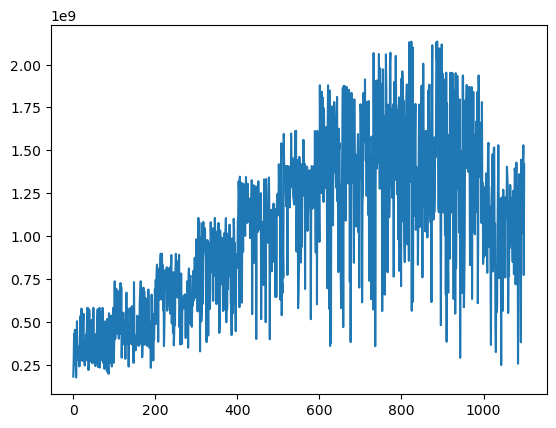

In [191]:
plt.plot(u_smoothed_real[0])

In [187]:
F0_real = F0_real.reshape((-1, F0_real.shape[-1]))

In [169]:
F0_real_norm = np.divide((F0_real - F0_mean), F0_std, where = (F0_std != 0))

In [133]:
u_smoothed_real[0].shape

(1100,)

In [177]:
k_new_real, preds_all_real = predictor(F0_real_norm)

(1100, 4000) (4000,)


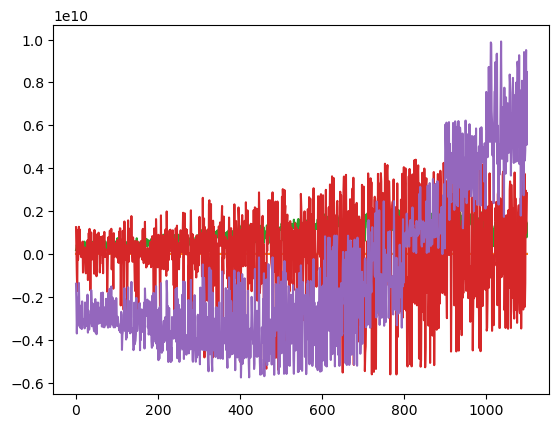

In [190]:
plt.plot(F0_real)

In [185]:
F0_real_norm.mean(axis=0)

array([ 4.44089210e-18,  8.99533756e+00,  2.40277639e+07,  2.55245600e+05,
       -3.13449300e+06])

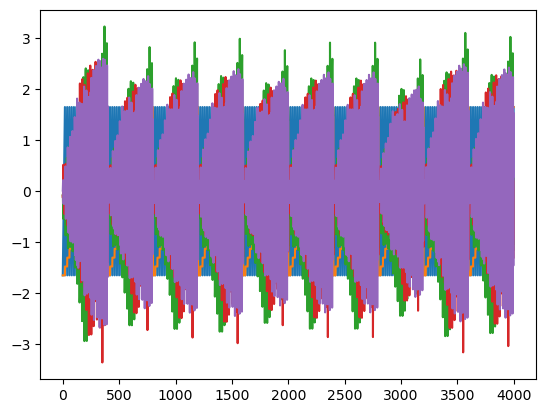

In [184]:
plt.plot(F0)

In [181]:
k_new_real.max()

0.0

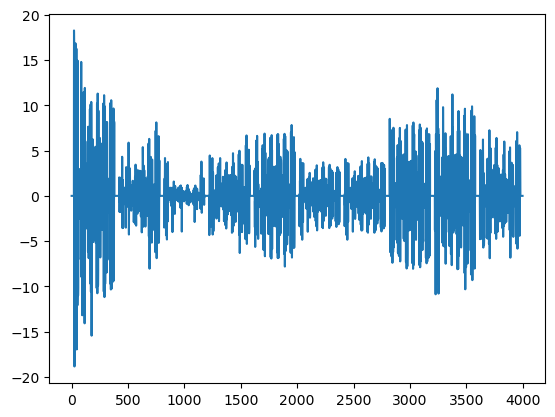

In [179]:
plt.plot(weight_vector)

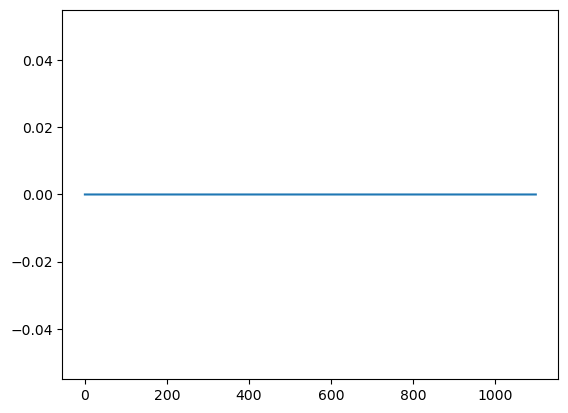

In [180]:
plt.plot(preds_all_real)

## JK new attempt

In [440]:
data = pd.read_csv('../RealData/Clean/SEEPS_Simulation_1.csv')

In [441]:
from sklearn import gaussian_process as gp
import statsmodels.api as sm
from scipy import stats as st

In [442]:
p_values = np.unique(data["p"].values)
p_values = np.sort(p_values)
p_values = np.flip(p_values)
tau_values = np.unique(data["tau"].values)
tau_values = np.sort(tau_values)

In [443]:
keys = ["y_rt", "y_rm", "y_rtm", "y_rmm"]

In [444]:
model_dict = {}

y_rt


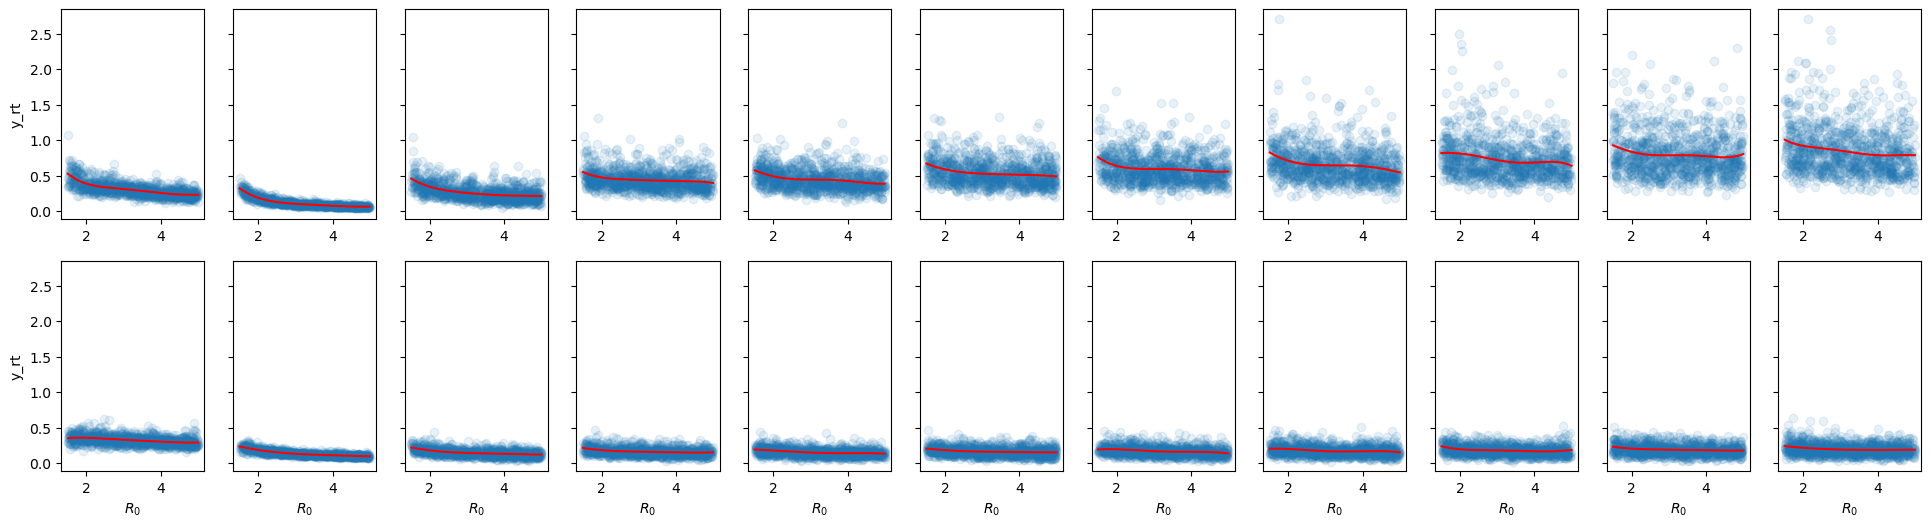

y_rm


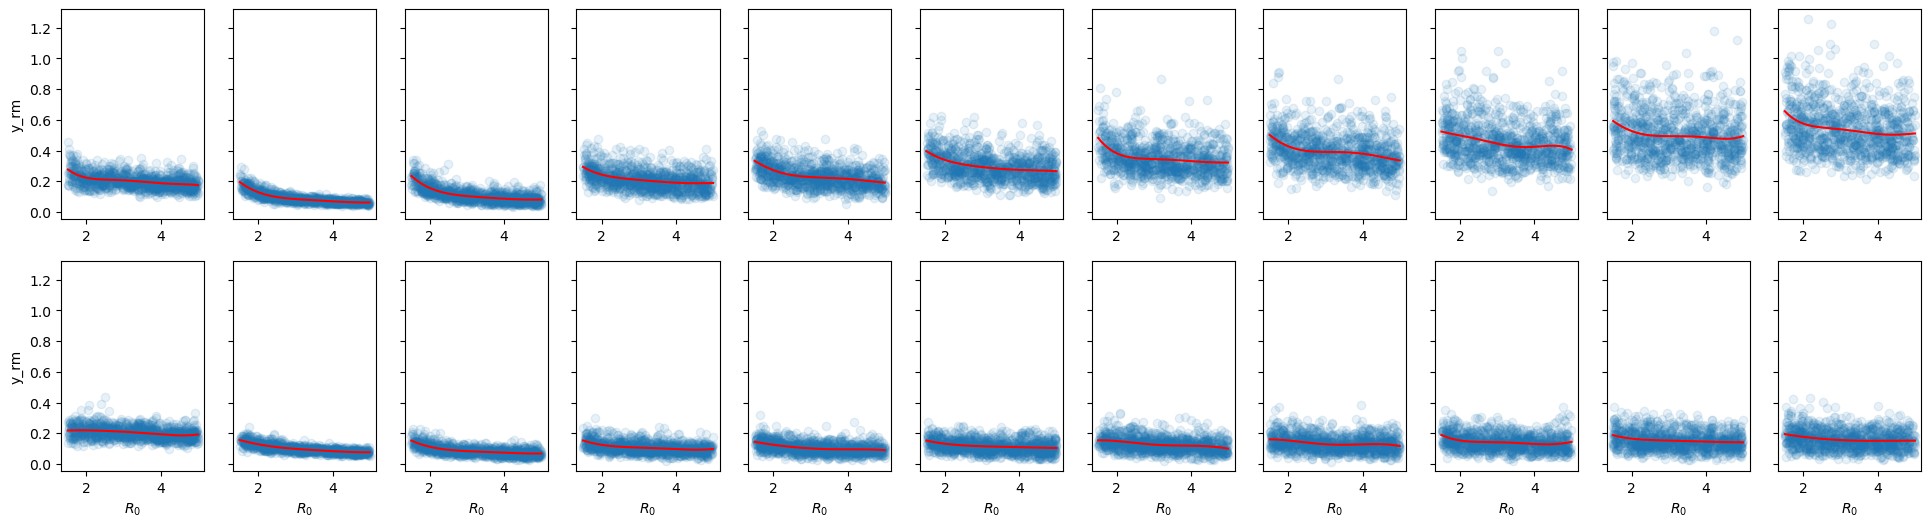

y_rtm


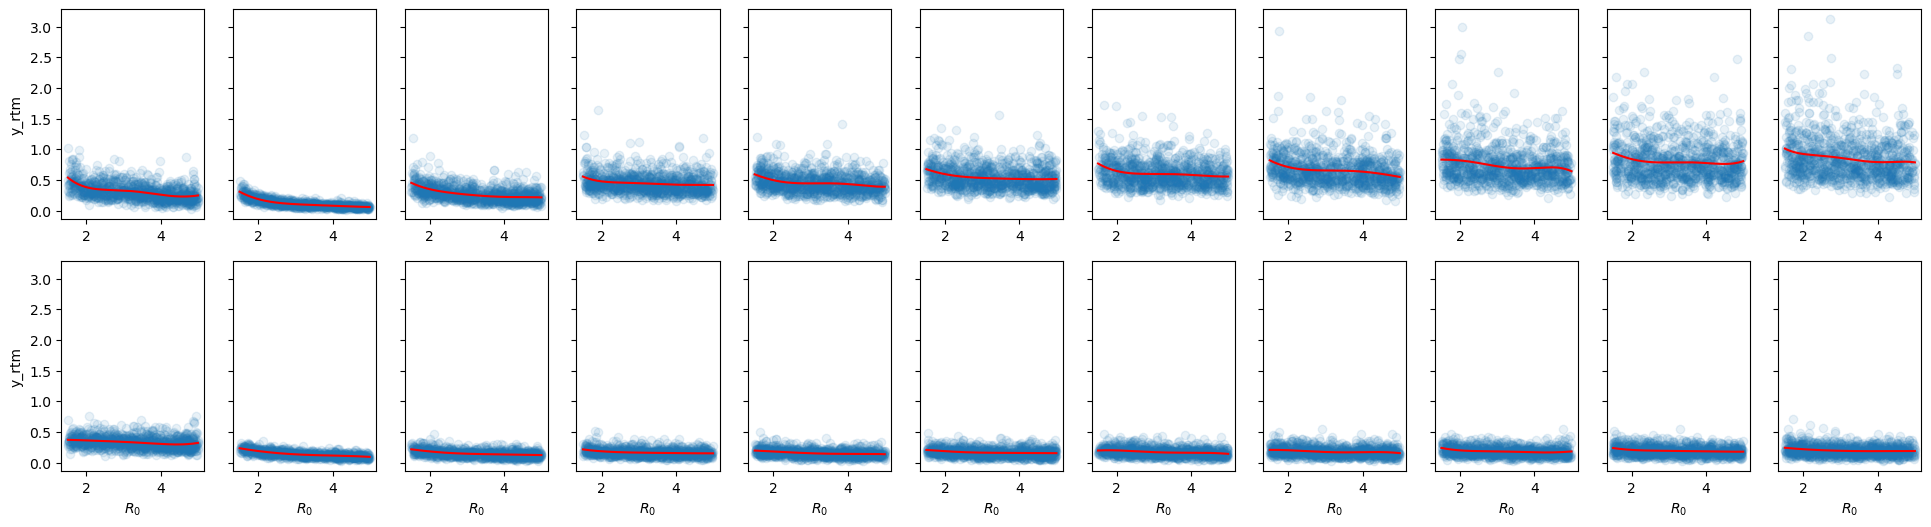

y_rmm


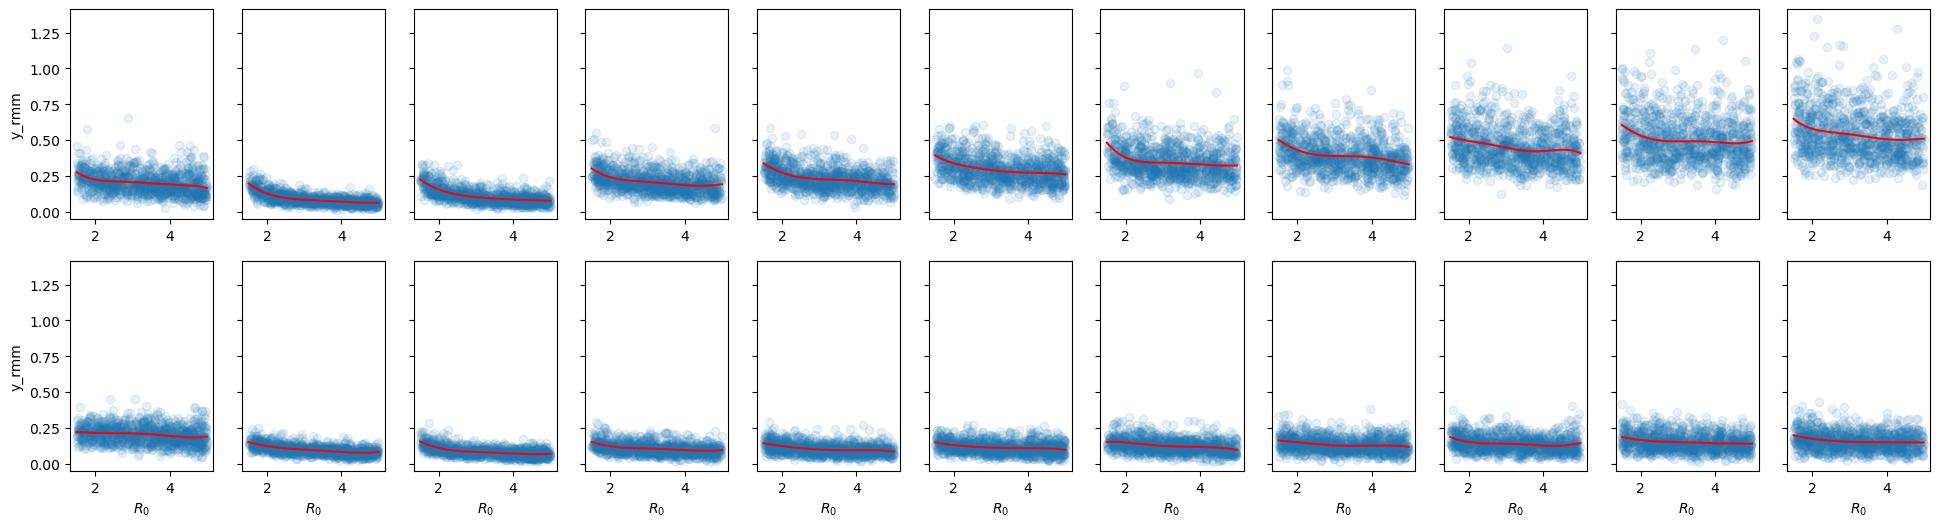

In [445]:
plotting_grid = np.linspace(np.min(data["R0"]), np.max(data["R0"]), 200)
preds_all = {}

preds_exact = {}

for key in keys:
    fig, ax = plt.subplots(2, 11, figsize=(24, 6), sharey=True)
    print(key)
    for pdx, p in enumerate(p_values):
        data_subset = data[data["p"] == p]
        for i, t in enumerate(tau_values):
            ds2 = data_subset[data_subset["tau"] == t]
            x = ds2["R0"].values
            y = ds2[key].values

            kernel = gp.kernels.RBF(length_scale=3, length_scale_bounds="fixed")
            model = gp.GaussianProcessRegressor(alpha=1e-4, kernel=kernel)
            model.fit(x.reshape(-1, 1), y)
            yp, ystd = model.predict(plotting_grid.reshape(-1, 1), return_std=True)
            preds_exact[(p, t, key)] = (x, y, model.predict(x.reshape(-1, 1), return_std=False))
            ax[pdx, i].scatter(x, y, alpha=0.1)
            ax[pdx, i].plot(plotting_grid, yp, color="red")
            model_dict[(p, t, key)] = model
            preds_all[(p, t, key)] = (plotting_grid, yp, ystd)
            if pdx == 1:
                ax[pdx, i].set_xlabel(r"$R_0$")
            if i == 0:
                ax[pdx, 0].set_ylabel(key)
    plt.show()

In [446]:

# let's extract the data
key_ = "y_rt"
pstar = 0.9
# preds_all[(p, t, key)] = (plotting_grid, yp, ystd)
grid_list = []
yp = []
xmean, xstd =0,0

x_plotting = None

for t in tau_values:
    xgrid_, ypred_, _ = preds_all[(pstar, t, key_)]
    # shift xgrid_ to mean 0 variance 1
    xmean, xstd = np.mean(xgrid_), np.std(xgrid_)
    x_plotting = xgrid_
    xgrid_ = (xgrid_ - xmean) / xstd
    grid = [(t / 120, x_) for x_ in xgrid_]  # Create a grid of points
    grid_list.extend(grid)
    yp.append(ypred_)

grid_array = np.asarray(grid_list)[np.newaxis, :, :]
ypred_ = np.asarray(yp).reshape(1,-1)

z_real, kdList_real, u_smoothed_real = KBio.kernel_smoothing(p_kernel, x_grid = grid_array, u_data = ypred_, f_data = None, alpha_list=alphas_list, nugget=nugget_smoothing)
# u_smoothed_real = [u[np.newaxis, :] for u in u_smoothed_real]

n_grid_pts:  2200


In [457]:
# same cell as above, but use a pstar = 0.1
key_ = "y_rt"
pstar = 0.1
# preds_all[(p, t, key)] = (plotting_grid, yp, ystd)
grid_list2 = []
yp2 = []
# x_plotting = None

for t in tau_values:
    xgrid_, ypred_, _ = preds_all[(pstar, t, key_)]
    # shift xgrid_ to mean 0 variance 1
    xgrid_ = (xgrid_ - xmean) / xstd
    grid = [(t / 120, x_) for x_ in xgrid_]  # Create a grid of points
    grid_list2.extend(grid)
    yp2.append(ypred_)

grid_array2 = np.asarray(grid_list2)[np.newaxis, :, :]
ypred_2 = np.asarray(yp2).reshape(1,-1)

_, _, u_smoothed_real2 = KBio.kernel_smoothing(p_kernel, x_grid = grid_array2, u_data = ypred_2, f_data = None, alpha_list=alphas_list, nugget=nugget_smoothing)

n_grid_pts:  2200


In [448]:
F0_real = KBio.assemble_features(x_grid_list=grid_list, u_smoothed=u_smoothed_real[0], multi_derivatives=u_smoothed_real[1:], function_list=feature_functions, flatten=False)
F0_real = F0_real.reshape((-1, F0_real.shape[-1]))

F0_real_mean, F0_real_std = np.mean(F0_real, axis=0), np.std(F0_real, axis=0)
F0_real_norm = np.divide((F0_real - F0_real_mean), F0_real_std, where = (F0_real_std != 0))

In [474]:
F0_real2 = KBio.assemble_features(x_grid_list=grid_list2, u_smoothed=u_smoothed_real2[0], multi_derivatives=u_smoothed_real2[1:], function_list=feature_functions, flatten=False)
F0_real2 = F0_real2.reshape((-1, F0_real2.shape[-1]))

# F0_real_mean2, F0_real_std2 = np.mean(F0_real2, axis=0), np.std(F0_real2, axis=0)
F0_real2_norm = np.divide((F0_real2 - F0_real_mean), F0_real_std, where = (F0_real_std != 0))

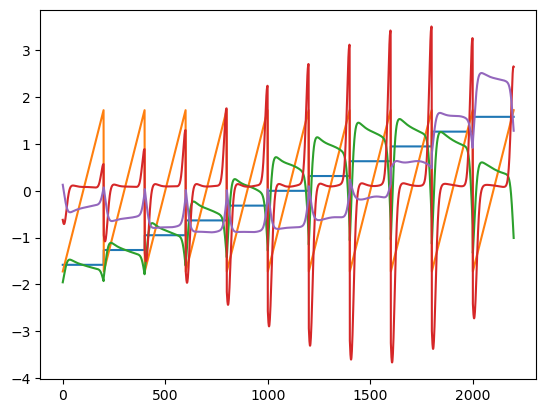

In [475]:
plt.plot(F0_real_norm)

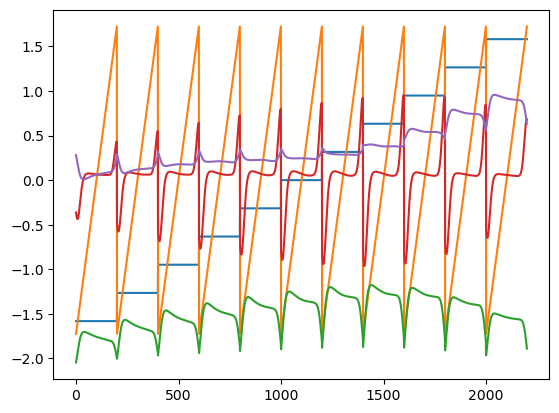

In [476]:
plt.plot(F0_real2_norm)

In [477]:
print(q)

Gaussian with sigma 0.5


In [478]:
k_new_real, preds_all_real = predictor(F0_real_norm)

(2200, 4000) (4000,)


In [479]:
k_new_real2, preds_all_real2 = predictor(F0_real2_norm)

(2200, 4000) (4000,)


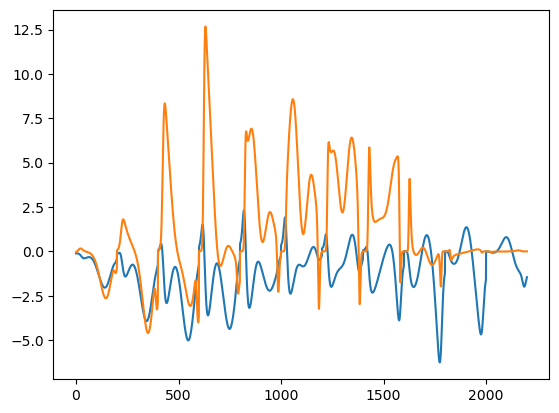

In [480]:
plt.plot(preds_all_real2)
plt.plot(preds_all_real)

In [481]:
# shape this into a new matrix, where each [i,:] corresponds to the i'th block of 20 points
preds_all_real_box = preds_all_real.reshape((len(tau_values), len(plotting_grid)))
preds_all_real_box2 = preds_all_real2.reshape((len(tau_values), len(plotting_grid)))

In [482]:
# import make_axes_locatable
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [487]:
import seaborn as sns
sns.set_style("darkgrid")

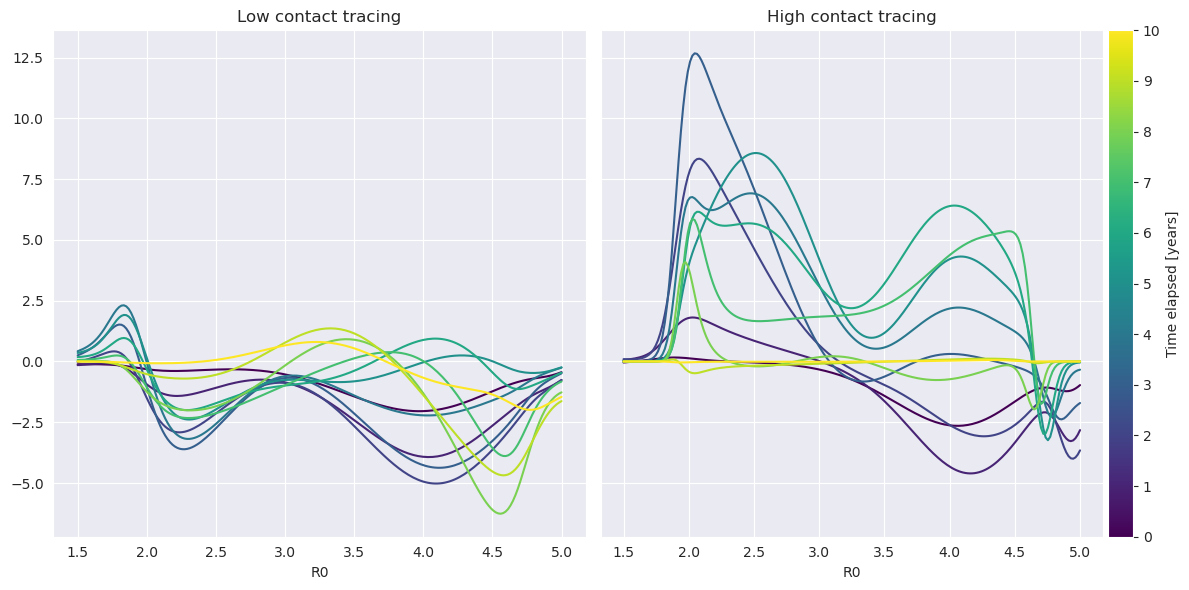

In [488]:
colors = plt.cm.viridis(np.linspace(0, 1, len(tau_values)))
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
for i in range(len(tau_values)):
    res = ax[0].plot(x_plotting, preds_all_real_box2[i,:], c=colors[i])

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
# plt.colorbar(cax=cax, orientation='vertical')
# set the colorbar max to 12 for the axis
colorbar = mpl.colorbar.ColorbarBase(cax, cmap=plt.cm.viridis, orientation='vertical', label="Time elapsed [years]", ticks=[x/10 for x in range(11)])
cax.set_yticklabels([f"{x}" for x in range(11)])

# do this for the right axis
# fig, ax = plt.subplots(1, 2, figsize=(6, 12))
for i in range(len(tau_values)):
    res = ax[1].plot(x_plotting, preds_all_real_box[i,:], c=colors[i])
ax[0].set_title("Low contact tracing")
ax[1].set_title("High contact tracing")
ax[0].set_xlabel("R0")
ax[1].set_xlabel("R0")
plt.tight_layout()

# Save figure to file
for fmt in ['pdf', 'png', 'svg', 'eps']:
    plt.savefig(f'../Figures/real_data_advection_preds.{fmt}', format=fmt)
    # plt.savefig(f'forcing_function_prediction_{fmt}.pdf', format=fmt)

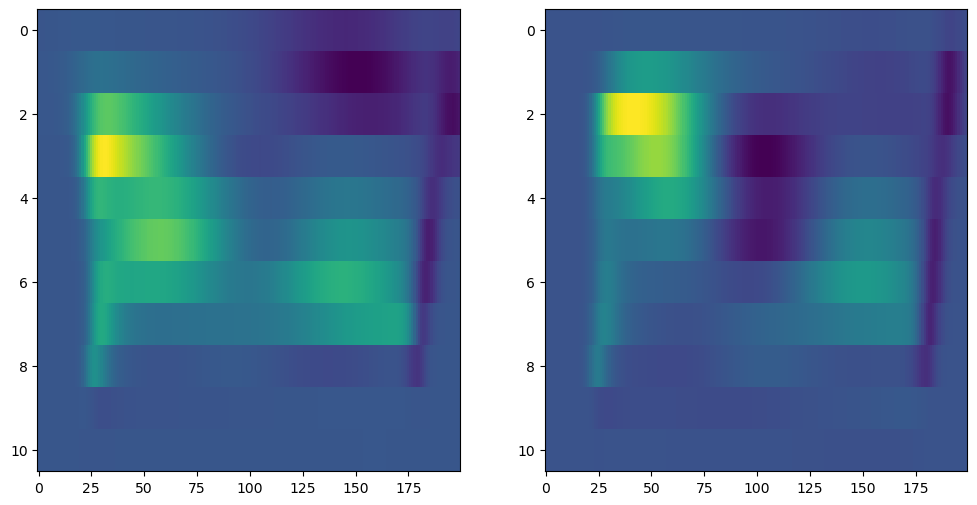

In [472]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(preds_all_real_box, interpolation='nearest', cmap=plt.cm.viridis)
ax[1].imshow(preds_all_real_box2, interpolation='nearest', cmap=plt.cm.viridis)
# set axis ratio to be equal
ax[0].set_aspect('auto', adjustable='box')
ax[1].set_aspect('auto', adjustable='box')

In [298]:
k_new_real.max()

0.9431971222526431

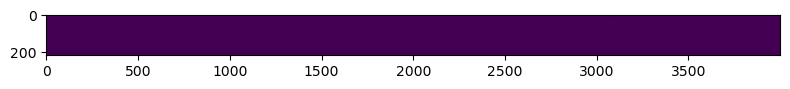

In [266]:
plt.figure(figsize=(8, 40))
plt.imshow(k_new_real)
plt.tight_layout()
plt.show()

In [241]:
grid_array.shape

(1, 220, 2)

In [242]:
ypred_.shape

(1, 220)

In [243]:
u_smoothed_real[0].shape

(220, 1)

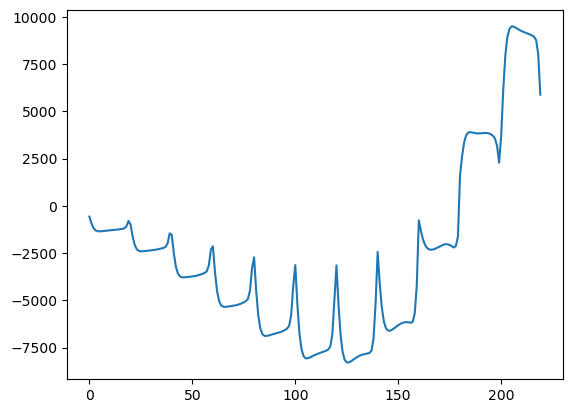

In [246]:
plt.plot(u_smoothed_real[2])